# Set up Conda Environment

In [7]:
!git clone https://github.com/Microsoft/computervision-recipes


fatal: destination path 'computervision-recipes' already exists and is not an empty directory.


In [2]:
!pip install -q condacolab
import condacolab
condacolab.install()
!conda env list

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:56
🔁 Restarting kernel...
# conda environments:
#
base                  *  /usr/local



In [1]:
!conda install pytorch==1.4.0 torchvision==0.5.0 cudatoolkit=10.0 -c pytorch -y
!conda install bqplot -y

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
\ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - cudatoolkit=10.0
    - pytorch==1.4.0
    - torchvision==0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _openmp_mutex-4.5          |       2_kmp_llvm           6 KB  conda-forge
    ca-certificates-2022.5.18.1|       ha878542_0         144 KB  conda-forge
    certifi-2022.5.18.1        |   py37h89c1867_0         150 KB  conda-forge
    conda-4.13.0               |   py37h89c1867_1         989 KB  conda-

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Load / install all the required libraries

In [4]:
!pip install patchify
!pip install scrapbook

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.3 MB 58.0 MB/s 
     |████████████████████████████████| 596 kB 68.0 MB/s 
     |████████████████████████████████| 96 kB 7.2 MB/s 


In [5]:
import sys
sys.path.append("./computervision-recipes")

import numpy as np
from pathlib import Path
import scrapbook as sc

import fastai
from fastai.metrics import accuracy
from fastai.vision import ( models, ImageList, imagenet_stats, partial, cnn_learner, ClassificationInterpretation, to_np, )
from fastai.vision import *
from fastai.callbacks.hooks import *

from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import db_num_workers, which_processor
from utils_cv.segmentation.data import Urls
from utils_cv.segmentation.dataset import read_classes
from utils_cv.segmentation.model import get_ratio_correct_metric, predict, confusion_matrix, print_accuracies
from utils_cv.segmentation.plot import plot_image_and_mask, plot_mask_stats, plot_segmentation, plot_confusion_matrix

print(f"Fast.ai version = {fastai.__version__}")
which_processor()

Fast.ai version = 1.0.61
Torch is using GPU: Tesla T4


In [6]:
import os
import sys
import glob
from PIL import Image
from patchify import patchify
import PIL
import cv2

# Connect to Google Collab and Unzip the folder into drive
Assuming all the folders have been created and image patches are defined in Part (C) 1st question.

In [10]:
from google.colab import drive
drive.mount("/content/drive")
%cd "/content/drive/My Drive"

Mounted at /content/drive
/content/drive/My Drive


# Assgin path to train and test folders in the drive

In [ ]:
#Used only in the case if we need to remove the complete folder. Or else no need.
#import shutil
#shutil.rmtree("/content/drive/MyDrive/pathologyData/pathdata/")

### Define the folder created in Part (c) 1st ques

In [11]:
ORG_TRAIN_PATH = '/content/drive/MyDrive/pathologyData/train/' #original train dataset
ORG_TEST_PATH = '/content/drive/MyDrive/pathologyData/test/'   #original test dataset

NEW_DATA_PATH = '/content/drive/MyDrive/pathologyData/pathdata/' #New folder to perform segmentation
IMAGE_PATH = '/content/drive/MyDrive/pathologyData/pathdata/images/' #all image folder 
MASK_PATH = '/content/drive/MyDrive/pathologyData/pathdata/segmentation-masks/' #all mask folder

# Assuming all the folders have been created and image patches are defined in Part (C) 1st question.

In [12]:
len(os.listdir(IMAGE_PATH))
len(os.listdir(MASK_PATH))

8325

# Defining model variables and Performing Data checks

In [13]:
# Path to data
DATA_PATH = '/content/drive/My Drive/pathologyData/pathdata/'

# Training parameters
EPOCHS = 8
LEARNING_RATE = 3e-4

# Reject all predictions with confidence lower than this threshold
THRESHOLD = None
IM_SIZE = np.array([100, 100])
ARCHITECTURE = models.vgg19_bn
BATCH_SIZE = 10


In [14]:
DATA_PATH = Path(DATA_PATH)
DATA_PATH.ls()

[PosixPath('/content/drive/My Drive/pathologyData/pathdata/images'),
 PosixPath('/content/drive/My Drive/pathologyData/pathdata/segmentation-masks'),
 PosixPath('/content/drive/My Drive/pathologyData/pathdata/classes.txt'),
 PosixPath('/content/drive/My Drive/pathologyData/pathdata/valid.txt'),
 PosixPath('/content/drive/My Drive/pathologyData/pathdata/.ipynb_checkpoints')]

In [15]:
im_path = DATA_PATH / "images"
im_paths = sorted(get_image_files(im_path))
im_paths[:3]

[PosixPath('/content/drive/My Drive/pathologyData/pathdata/images/10256_500_f00001_original_00.tif'),
 PosixPath('/content/drive/My Drive/pathologyData/pathdata/images/10256_500_f00001_original_01.tif'),
 PosixPath('/content/drive/My Drive/pathologyData/pathdata/images/10256_500_f00001_original_02.tif')]

In [16]:
anno_path = DATA_PATH / "segmentation-masks"
mask_paths = sorted(get_image_files(anno_path))
mask_paths[:3]

[PosixPath('/content/drive/My Drive/pathologyData/pathdata/segmentation-masks/10256_500_f00001_original_00.png'),
 PosixPath('/content/drive/My Drive/pathologyData/pathdata/segmentation-masks/10256_500_f00001_original_01.png'),
 PosixPath('/content/drive/My Drive/pathologyData/pathdata/segmentation-masks/10256_500_f00001_original_02.png')]

In [17]:
get_gt_filename = lambda x: anno_path / f"{x.stem}.png" # Function  to fetch all respective mask image of any image which will be later called in image segmentation

In [18]:
# Reading classes
classes_path = DATA_PATH / "classes.txt"
classes = np.loadtxt(classes_path, dtype=str)
classes

array(['background', 'void', 'void', 'void', ..., 'void', 'void', 'void', 'foreground'], dtype='<U10')

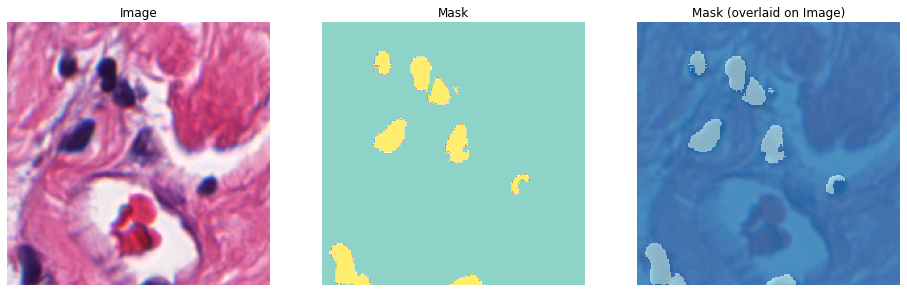

In [19]:
# Plot images and masks
plot_image_and_mask(im_paths[0],mask_paths[0],  alpha=0.8)

# Image Segmentation Block

In [20]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [21]:
data = (
    SegmentationItemList.from_folder(im_path)
    .split_by_fname_file('../valid.txt')  #example how to implement a dedicated split 
    .label_from_func(get_gt_filename, classes=classes)
    .transform(get_transforms(), resize_method = ResizeMethod.CROP, size=IM_SIZE, tfm_y=True)
    .databunch(bs=BATCH_SIZE, num_workers=db_num_workers())
    .normalize(imagenet_stats)
)

In [22]:
data.show_batch

<bound method DataBunch.show_batch of ImageDataBunch;

Train: LabelList (5925 items)
x: SegmentationItemList
Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100)
y: SegmentationLabelList
ImageSegment (1, 100, 100),ImageSegment (1, 100, 100),ImageSegment (1, 100, 100),ImageSegment (1, 100, 100),ImageSegment (1, 100, 100)
Path: /content/drive/My Drive/pathologyData/pathdata/images;

Valid: LabelList (2400 items)
x: SegmentationItemList
Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100)
y: SegmentationLabelList
ImageSegment (1, 100, 100),ImageSegment (1, 100, 100),ImageSegment (1, 100, 100),ImageSegment (1, 100, 100),ImageSegment (1, 100, 100)
Path: /content/drive/My Drive/pathologyData/pathdata/images;

Test: None>

In [23]:
print(f"Number of images: {len(data.y.items)}")
print(f"Classes: {data.classes}")

Number of images: 5925
Classes: ['background' 'void' 'void' 'void' ... 'void' 'void' 'void' 'foreground']


### Checking for void values in the classest.txt

In [29]:
#Mapping void to unused class ID
class2id = {v:k for k,v in enumerate(data.classes)}
if 'void' in class2id:
  void_code = class2id['void']
else: 
  void_code = -100

class2id

{'background': 0, 'foreground': 255, 'void': 254}

### Unet Learner with VGG-19 Backbone

In [27]:
learn = unet_learner(
    data, 
    ARCHITECTURE, 
    wd=1e-2, 
    metrics=get_ratio_correct_metric([0,255])
)


Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,ratio_correct,time
0,0.213344,0.182529,0.921015,13:18
1,0.190841,0.177392,0.926761,04:38
2,0.186015,0.171271,0.924514,04:48
3,0.166668,0.154359,0.933553,04:50
4,0.161535,0.160794,0.931734,04:49
5,0.154443,0.147532,0.936878,04:51
6,0.152410,0.146041,0.937506,04:50
7,0.157651,0.144571,0.938148,04:49


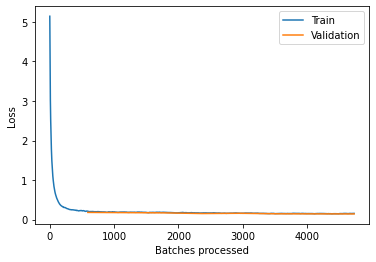

In [28]:
learn.unfreeze()
learn.fit_one_cycle(EPOCHS, LEARNING_RATE) 
learn.recorder.plot_losses()

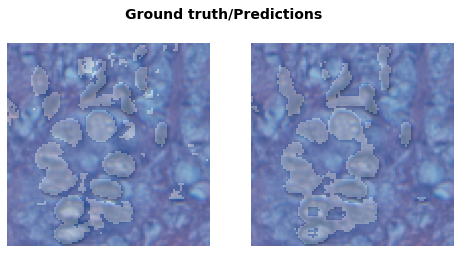

In [30]:
learn.show_results(rows=1)

### Class wise accuracy. 0: Background, 255: Foreground

In [31]:
cmat, cmat_norm = confusion_matrix(learn, data.valid_dl)
accs = print_accuracies(cmat, cmat_norm, [0,255])

Overall accuracy: 93.41%
Class-averaged accuracy: 89.77%
	Class               0 has accuracy: 95.67%
	Class             255 has accuracy: 83.87%
